# Bidirectional Recurrent Units

For language modeling, i.e. predicting the next token, it makes sense to condition on the leftward context. However, it also makes sense to look at words from the right to fully understand a sentence. For example, a common task[^1] is to mask out random tokens in a text document and then to train a sequence model to predict the values of the missing tokens. Depending on what comes after the blank, the likely value of the missing token changes dramatically:

```text
I am ___.
I am ___ tired.
I am ___ tired, and I can sleep all day.
```

Clearly the meaning change by reading more into the sentence.
The likely candidates change (e.g. "happy", "not", and "very" ), even when the tokens on the left 
of the blank are the same. Note that bidirectional RNNs typically only used in the *encoding* part of a system[^2] since the rightward context is not available at inference.

[^1]: Often useful for model pretraining prior to fine-tuning on an actual task of interest.

[^2]: Encoding refers to ingesting an input sequence $\boldsymbol{\mathsf{x}}$ to get a state vector $\boldsymbol{\mathsf{h}}$ that, in principle, distills the relevant information in that sequence relative to the downstream task. For example, recall in text generation $\boldsymbol{\mathsf{h}} = \text{RNN}(\boldsymbol{\mathsf{x}}_{\text{prompt}})$ is the encoding used to start the *decoding* process, i.e. using the state vector and the model's generative capabilities to produce text.

<br>

## Bidirectional computation

A simple technique transforms any RNN unit (e.g. LSTM, GRU) into a bidirectional unit {cite}`birnn`. 
The input sequence is simply processed in opposing directions. Then, outputs for the same inputs are concatenated for downstream processing. The states are processed independently in the expected order. 

More precisely, let $G$ be a recurrent unit. For $t = 1, \ldots, T$, the forward direction computes:


$$
\boldsymbol{\mathsf{O}}^f_t, \boldsymbol{\mathsf{H}}^f_t = G(\boldsymbol{\mathsf{X}}_t, \boldsymbol{\mathsf{H}}^f_{t-1})
$$

Meanwhile, the backward direction calculates: 

$$
\boldsymbol{\mathsf{O}}^b_{T - t + 1}, \boldsymbol{\mathsf{H}}^b_t = G(\boldsymbol{\mathsf{X}}_{T - t + 1}, \boldsymbol{\mathsf{H}}^b_{t-1})
$$

Finally, the output sequence is given by 

$$(\boldsymbol{\mathsf{O}}^f_t \oplus \boldsymbol{\mathsf{O}}^b_t)_{t=1}^T.$$ 

Note that input indices have to be matched. This is illustrated in {numref}`05-birnn`.

<br>

```{figure} ../../../img/nn/05-birnn.png
---
width: 670px
name: 05-birnn
align: center
---
Building the output vectors (right) in a bidirectional recurrent computation.
```

<br>

## Code implementation

In [1]:
from chapter import *
import certifi
import ssl
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

Creating a **Bidirectional** wrapper unit to convert any to a bidirectional RNN cell:

In [2]:
%%save
from functools import partial

class BiRNN(RNNBase):
    def __init__(self, 
        cell: Type[RNNBase],
        inputs_dim: int, hidden_dim: int, 
        **kwargs
    ):
        super().__init__(inputs_dim, hidden_dim)
        assert hidden_dim % 2 == 0
        self.frnn = cell(inputs_dim, hidden_dim // 2, **kwargs)
        self.brnn = cell(inputs_dim, hidden_dim // 2, **kwargs)
        
    def init_state(self, x):
        return (None, None)

    def compute(self, x, state):
        fh, bh = state
        fo, fh = self.frnn(x, fh)
        bo, bh = self.brnn(torch.flip(x, [0]), bh)  # Flip seq index: (T, B, d)
        bo = torch.flip(bo, [0])                    # Flip back outputs. See above
        outs = torch.cat([fo, bo], dim=-1)
        return outs, (fh, bh)


Bidirectional = lambda cell: partial(BiRNN, cell)

from functools import partial

class BiRNN(RNNBase):
    def __init__(self, 
        cell: Type[RNNBase],
        inputs_dim: int, hidden_dim: int, 
        **kwargs
    ):
        super().__init__(inputs_dim, hidden_dim)
        assert hidden_dim % 2 == 0
        self.frnn = cell(inputs_dim, hidden_dim // 2, **kwargs)
        self.brnn = cell(inputs_dim, hidden_dim // 2, **kwargs)
        
    def init_state(self, x):
        return (None, None)

    def compute(self, x, state):
        fh, bh = state
        fo, fh = self.frnn(x, fh)
        bo, bh = self.brnn(torch.flip(x, [0]), bh)  # Flip seq index: (T, B, d)
        bo = torch.flip(bo, [0])                    # Flip back outputs. See above
        outs = torch.cat([fo, bo], dim=-1)
        return outs, (fh, bh)


Bidirectional = lambda cell: partial(BiRNN, cell)

**Remark.** For consistency with `LanguageModel`, we expect that the `hidden_dim` parameter is the size of the combined forward and backward outputs. This is so that the linear layer matches the given parameter. In other words, we halve the hidden size of each RNN cell inside the bidirectional model.

Flip function works as follows:

In [3]:
l = [[i, 2 * i] for i in range(6)]
a = torch.tensor(l).reshape(-1, 3, 2)
a

tensor([[[ 0,  0],
         [ 1,  2],
         [ 2,  4]],

        [[ 3,  6],
         [ 4,  8],
         [ 5, 10]]])

Only time dimension is affected by flip:

In [4]:
torch.flip(a, [0])

tensor([[[ 3,  6],
         [ 4,  8],
         [ 5, 10]],

        [[ 0,  0],
         [ 1,  2],
         [ 2,  4]]])

**Shapes.** Recall LSTM has two states. And one state vector for each input sequence:

In [5]:
blstm = Bidirectional(LSTM)(28, 128)
x = torch.randn(30, 32, 28)
outs, (fstate, bstate) = blstm(x)
assert outs.shape == (30, 32, 128)
assert fstate[0].shape == (32, 64), fstate[1].shape == (32, 64)
assert bstate[0].shape == (32, 64), bstate[1].shape == (32, 64)

Our implementation differs a bit with PyTorch where hidden size is doubled:

In [6]:
blstm_torch = nn.LSTM(28, 64, bidirectional=True)
for net in [blstm, blstm_torch]:
    for name, p in net.named_parameters():
        if "bias" in name:
            p.data.fill_(0.0)
        else:
            p.data.fill_(1.0)

error = torch.abs(blstm(x)[0] - blstm_torch(x)[0]).max()
print(error)
assert error < 5e-6

tensor(8.9407e-07, grad_fn=<MaxBackward1>)


Adding depth still works:

In [7]:
blstm = Deep(Bidirectional(LSTM))(28, 128, num_layers=2)
blstm_torch = nn.LSTM(28, 64, bidirectional=True, num_layers=2)
for net in [blstm, blstm_torch]:
    for name, p in net.named_parameters():
        if "bias" in name:
            p.data.fill_(0.0)
        else:
            p.data.fill_(1.0)

error = torch.abs(blstm(x)[0] - blstm_torch(x)[0]).max()
print(error)
assert error < 1e-5

tensor(0., grad_fn=<MaxBackward1>)


**Remark.** *Bidirectional first, then deep.* We will train such a model below. This allows each layer to benefit from the bidirectional context before passing it to the next layer, i.e. the higher-order states also look at the previous states in two directions. The zero error above shows that this setup is consistent with the PyTorch implementation.

<br>

## Model training

**Demo.** Training a BiLSTM based sentiment classifier on the [IMDB movie review](https://keras.io/api/datasets/imdb/) dataset:

In [8]:
import keras
import torch
from torch.utils.data import TensorDataset, DataLoader

def collate_fn(batch):
    """Transforming the data to sequence-first format."""
    x, y = zip(*batch)
    x = torch.stack(x, 1)      # (T, B, vocab_size)
    y = torch.stack(y, 0)      # (B,)
    return x, y


BATCH_SIZE = 32
MAX_WORDS = 20_000      # Only top 20k words
T = 200                 # Only 200 words of each movie review

# Load. Trim or pad sequences to length T
(x_train, y_train), (x_valid, y_valid) = keras.datasets.imdb.load_data(num_words=MAX_WORDS)
x_train = keras.utils.pad_sequences(x_train, maxlen=T)
x_valid = keras.utils.pad_sequences(x_valid, maxlen=T)
print(x_train.shape, x_valid.shape)

train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train).long())
valid_dataset = TensorDataset(torch.tensor(x_valid), torch.tensor(y_valid).long())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)    # also sampled

(25000, 200) (25000, 200)


In [9]:
from tqdm.notebook import tqdm

def train_step(model, optim, x, y, max_norm) -> float:
    loss = F.cross_entropy(model(x), y)
    loss.backward()
    
    clip_grad_norm(model, max_norm=max_norm)
    optim.step()
    optim.zero_grad()
    return loss.item()

@torch.no_grad()
def valid_step(model, x, y) -> float:
    loss = F.cross_entropy(model(x), y)
    return loss.item()

class LastElement(nn.Module):
    """Get last element of a rank-3 tensor of shape (B, T, h)."""
    def forward(self, x):
        return x[0][-1]


DEVICE = "mps"
LR = 0.001
EPOCHS = 3
MAX_NORM = 5.0
EMBED_DIM = 256
HIDDEN_DIM = 128

emb = nn.Embedding(MAX_WORDS, EMBED_DIM)
rnn = Deep(Bidirectional(nn.LSTM))(EMBED_DIM, HIDDEN_DIM, num_layers=3)
model = nn.Sequential(emb, rnn, LastElement(), nn.Dropout(0.5), nn.Linear(HIDDEN_DIM, 2))
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LR)

train_loss = []
valid_loss = []
valid_accs = []

for e in tqdm(range(EPOCHS)):
    for t, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        loss = train_step(model, optim, x, y, MAX_NORM)
        train_loss.append(loss)

        if t % 5 == 0:
            xv, yv = next(iter(valid_loader))
            xv = xv.to(DEVICE)
            yv = yv.to(DEVICE)
            valid_loss.append(valid_step(model, xv, yv))
            valid_accs.append((model(xv).argmax(dim=1) == yv).float().mean().item())

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

In [10]:
# evaluation (accuracy)
c = 0
for xv, yv in tqdm(valid_loader):
    xv = xv.to(DEVICE)
    yv = yv.to(DEVICE)
    c += (model(xv).argmax(dim=1) == yv).int().sum().item()

print(c / len(valid_dataset))

  0%|          | 0/782 [00:00<?, ?it/s]

0.88288


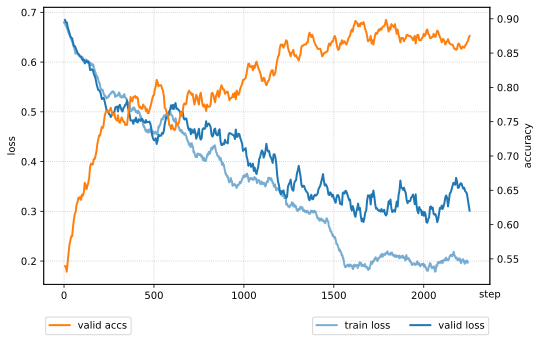

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")
fig, ax1 = plt.subplots(figsize=(8, 5))

WINDOW_SIZE = 20
train_loss = np.array(train_loss)
valid_loss = np.array(valid_loss)
valid_accs = np.array(valid_accs)
train_loss_avg = [train_loss[i-WINDOW_SIZE * 5:i].mean() for i in range(WINDOW_SIZE * 5, len(train_loss))]
valid_loss_avg = [valid_loss[i-WINDOW_SIZE:i].mean() for i in range(WINDOW_SIZE, len(valid_loss))]
valid_accs_avg = [valid_accs[i-WINDOW_SIZE:i].mean() for i in range(WINDOW_SIZE, len(valid_accs))]

ax1.plot(train_loss_avg, linewidth=2, alpha=0.6, label="train loss", color="C0")
ax1.set_xlabel("step")
ax1.grid(axis="both", linestyle="dotted", alpha=0.8)
ax2 = ax1.twinx()
ax1.plot(np.array(range(1, len(valid_loss_avg) + 1)) * 5, valid_loss_avg, linewidth=2, label="valid loss", color="C0")
ax2.plot(np.array(range(1, len(valid_accs_avg) + 1)) * 5, valid_accs_avg, linewidth=2, label="valid accs", color="C1")

# ax1.yaxis.label.set_color("C0")
# ax2.yaxis.label.set_color("C1")
ax1.set_ylabel("loss", fontsize=10)
ax2.set_ylabel("accuracy", fontsize=10)
ax1.xaxis.set_label_coords(1.00, -0.020)
ax1.legend(loc="lower right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)
ax2.legend(loc='upper center', bbox_to_anchor=(0.1, -0.10), ncol=5)
ax1.legend(loc='lower center', bbox_to_anchor=(0.8, -0.20), ncol=5)